# 0. Setup Paths

In [ ]:
import os

In [ ]:
CUSTOM_MODEL_NAME = 'my_faster_rcnn'
PRETRAINED_MODEL_NAME = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection
if os.name=='posix':
    !apt-get protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e .

E: Invalid operation protobuf-compiler
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1697012 sha256=7013483f67853dadb0fea6681e66ad1afdc8ca654995d1446a9723edd7bfc608
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4rsbr8r/wheels/fb/c9/43/709f88e66b36649c7a29812ca4f6236f31caed949aabc3e335
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow --upgrade

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [ ]:
pipeline_config.model.faster_rcnn.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!{command}

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
!pip install numpy==1.23

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars44.png')

Instructions for updating:
Use ref() instead.


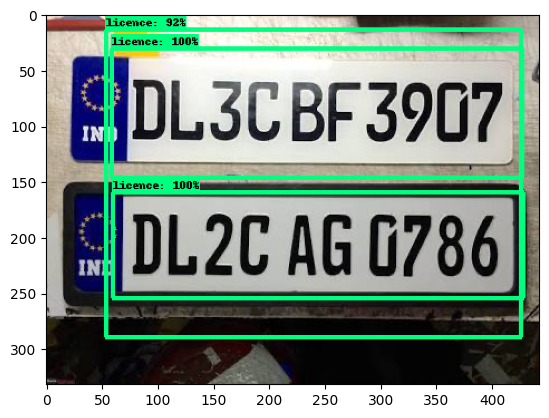

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.4,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# Real Time detection with video file


In [ ]:
!pip install scikit-learn scikit-image filterpy

In [ ]:
!git clone "https://github.com/computervisioneng/deep_sort" "/content/Tensorflow/workspace/deep_sort"

In [ ]:
!cp '/content/drive/MyDrive/Video + model/mars-small128.pb' '/content/Tensorflow/workspace/model_data'

In [ ]:
import tensorflow as tf

with tf.Session() as sess:
    with tf.gfile.FastGFile('/content/Tensorflow/workspace/model_data/mars-small128.pb','rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

AttributeError: ignored

In [ ]:
import sys
sys.path.append('/content/Tensorflow/scripts')
sys.path.append('/content/Tensorflow/workspace')
sys.path.append('/content/Tensorflow/workspace/model_data')


mars-small128.pb


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

from deep_sort_realtime.deep_sort import nn_matching
from deep_sort_realtime.deep_sort.detection import Detection
from deep_sort_realtime.deepsort_tracker import Tracker

from tracker import Tracker
from ultralytics import YOLO
import random

model = YOLO('yolov8n.pt')

tracker = Tracker()
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for j in range(10)]

detection_threshold = 0.5


#from generate_detections import * as gdet
'''
# Initialize the DeepSORT tracker
max_cosine_distance = 0.5
nn_budget = None
nms_max_overlap = 1.0
metric = nn_matching.NearestNeighborDistanceMetric(
    "cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)
'''
# Initialize the frame counter and ID counter
frame_count = 0
id_count = 0

# Path to video file
video_path = '/content/Tensorflow/workspace/short2.mp4'

# Path to output video file
output_path = '/content/Tensorflow/workspace/output/output.mp4'

# Load the label maps
pretrained_label_map_path = '/content/Tensorflow/models/research/object_detection/data/mscoco_label_map.pbtxt'
pretrained_category_index = label_map_util.create_category_index_from_labelmap(pretrained_label_map_path, use_display_name=True)

custom_label_map_path = '/content/Tensorflow/workspace/annotations/label_map.pbtxt'
custom_category_index = label_map_util.create_category_index_from_labelmap(custom_label_map_path, use_display_name=True)

# Load the pre-trained model
pretrained_model_path = '/content/Tensorflow/workspace/pre-trained-models/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/saved_model/'
pretrained_detect_fn = tf.saved_model.load(pretrained_model_path)

#custom model has already loaded will move code here later

# Open the video file
cap = cv2.VideoCapture(video_path)

# Set the minimum speed threshold for capturing a snapshot
MIN_SPEED_THRESHOLD = 20  # km/hr

# Get the frame width and height
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (width, height))

line1 = [(0, 500), (width, 500)] # line to detect objects
line2 = [(0, 200), (width, 200)] # line to calculate speed


def calculate_speed(track):
    # Get the distance that the track has moved since it crossed the first line
    distance = track.distance
    if distance is None:
        return 0

    # Get the number of frames that have passed since the track crossed the first line
    frames = track.frames_since_first_seen
    if frames is None or frames <= 0:
        return 0

    # Calculate the speed in pixels per frame
    speed = distance / frames

    return speed


# Loop through the video frames
while cap.isOpened():
    ret, orig_frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        break
    frame_count += 1

    # Use the original frame for object detection
    frame = orig_frame.copy()

    #converting it RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = model(frame)

    for result in results:
        detections = []
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = r
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            class_id = int(class_id)
            if score > detection_threshold :
                detections.append([x1, y1, x2, y2, score])

        tracker.update(frame, detections)

    #----------------------------------------------
    '''
    # Run object detection on the pre-trained model
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, 0), dtype=tf.float32)
    input_tensor = tf.cast(input_tensor, dtype=tf.uint8)
    detections_pretrained = pretrained_detect_fn(input_tensor)

    num_detections_pretrained = int(detections_pretrained.pop('num_detections'))
    detections_pretrained = {key: value[0, :num_detections_pretrained].numpy()
                  for key, value in detections_pretrained.items()}
    detections_pretrained['num_detections'] = num_detections_pretrained

    # Filter out low confidence detections and convert them to Detection objects
    print(detections_pretrained['detection_boxes'])
    bboxes = detections_pretrained['detection_boxes']
    scores = detections_pretrained['detection_scores']
    detections_pretrained = [Detection(bbox, confidence, None) for bbox, confidence in zip(bboxes, scores) if confidence > 0.5]

    # Perform non-maximum suppression to remove duplicate detections
    boxes = np.array([d.to_xyah() for d in detections_pretrained])
    scores = np.array([d.confidence for d in detections_pretrained])
    indices = non_max_suppression(boxes, nms_max_overlap, scores)
    detections_pretrained = [detections_pretrained[i] for i in indices]

    # Generate detection features for use with DeepSORT
    features = np.array([d.feature for d in detections_pretrained])
    detections_pretrained = [Detection(bbox, confidence, feature) for bbox, confidence, feature in zip(boxes, scores, features)]

    # Pass the detections to the DeepSORT tracker and update its track list
    tracker.predict()
    tracker.update(detections_pretrained)
    '''

    # Check if each track has crossed the two counting lines
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue

        # Get the bounding box coordinates from the tracker
        bbox = track.to_tlbr()

        # Calculate the center point of the bounding box
        center = (int((bbox[0] + bbox[2]) / 2), int((bbox[1] + bbox[3]) / 2))

        # Check if the center point crosses the first line
        if center[1] > 500 and cv2.pointPolygonTest(np.array(line1), center, False) >= 0:
            if not track.counted:
                track.counted = True
                track.id = id_count
                id_count += 1
                print(f"Object with ID {track.id} has crossed the first line.")

        # Check if the center point crosses the second line
        elif center[1] > 500 and cv2.pointPolygonTest(np.array(line2), center, False) >= 0:
            if not track.counted:
                track.counted = True
                speed = calculate_speed(track)
                print(f"Object with ID {track.id} has crossed the second line at a speed of {speed} pixels per frame.")
                # Draw the speed on the frame
            cv2.putText(orig_frame, f"Speed: {speed} px/frame", (center[0] - 10, center[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Draw the counting lines on the frame
    cv2.line(orig_frame, line1[0], line1[1], (0, 0, 255), 2)
    cv2.line(orig_frame, line2[0], line2[1], (0, 0, 255), 2)

    #----------------------

    # Run object detection on the frame
    input_tensor = tf.convert_to_tensor(np.expand_dims(frame, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    #----------------------------------------------

    # Draw the bounding boxes on the original frame
    label_id_offset = 1
    viz_utils.visualize_boxes_and_labels_on_image_array(
                orig_frame,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                custom_category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.5,
                agnostic_mode=False)

    #----------------------------------------------

    # Draw the two lines on the original frame
    #cv2.line(orig_frame, line1[0], line1[1], color=(0, 255, 0), thickness=2)
    #cv2.line(orig_frame, line2[0], line2[1], color=(0, 0, 255), thickness=2)



    # Write the frame to the output video
    out.write(orig_frame)

# Release the video capture and writer objects
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()




NotFoundError: ignored

In [ ]:
!cp '/content/drive/MyDrive/Video + model/short2.mp4' '/content/Tensorflow/workspace/'

In [ ]:
!cp '/content/Tensorflow/workspace/output/output3.mp4' '/content/drive/MyDrive/Video + model/'

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow/workspace/models/my_faster_rcnn/pipeline.config --trained_checkpoint_dir=Tensorflow/workspace/models/my_faster_rcnn --output_directory=Tensorflow/workspace/models/my_faster_rcnn/export


In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!fusermount -u /content/drive


In [ ]:
!rm -rf /content/Tensorflow/workspace/images/

In [ ]:
!unzip /content/Tensorflow/workspace/testing.zip -d /content/Tensorflow/workspace/

In [ ]:
!cp "/content/drive/MyDrive/Video + model/TEST(1).mp4" "/content/Tensorflow/workspace"

In [ ]:
!cp "/content/models(eff-detnet-10k).tar.gz" "/content/drive/MyDrive/Video + model/"

# Copying project from drive and unzipping it

In [ ]:
!cp "/content/drive/MyDrive/Video + model/Tensorflow.zip" "/content"

In [ ]:
!unzip "/content/Tensorflow.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Tensorflow/workspace/images/train/0150.png  
  inflating: /content/Tensorflow/workspace/images/train/Cars124.png  
  inflating: /content/__MACOSX/Tensorflow/workspace/images/train/._Cars124.png  
  inflating: /content/Tensorflow/workspace/images/train/0178.png  
  inflating: /content/Tensorflow/workspace/images/train/Cars130.png  
  inflating: /content/__MACOSX/Tensorflow/workspace/images/train/._Cars130.png  
  inflating: /content/Tensorflow/workspace/images/train/Cars12.xml  
  inflating: /content/__MACOSX/Tensorflow/workspace/images/train/._Cars12.xml  
  inflating: /content/Tensorflow/workspace/images/train/0193.xml  
  inflating: /content/Tensorflow/workspace/images/train/0187.xml  
  inflating: /content/Tensorflow/workspace/images/train/Cars130.xml  
  inflating: /content/__MACOSX/Tensorflow/workspace/images/train/._Cars130.xml  
  inflating: /content/Tensorflow/workspace/images/train/0178.xml  
  inflating:

In [ ]:
!rm -rf "/content/Tensorflow.zip"

In [ ]:
!rm -rf "/content/__MACOSX"

In [ ]:
!cp "/content/drive/MyDrive/archive.tar.gz" "/content/Tensorflow/workspace/images"

In [ ]:
!cp '/content/drive/MyDrive/Video + model/models(10k).tar.gz' '/content/Tensorflow/'

In [ ]:
!tar -xzf /content/Tensorflow/models10k.tar.gz -C /content/Tensorflow/

In [ ]:
!rm -rf '/content/Tensorflow'

In [ ]:
!rm -rf '/content/Tensorflow/Tensorflow'

In [ ]:
!rm -rf '/content/Tensorflow/workspace/models/my_faster_rcnn_3'

# Copy Dataset from drive to colab


In [ ]:
!cp '/content/drive/MyDrive/Video + model/archive.tar.gz' '/content/Tensorflow/workspace/images'